[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
4/4 [==============================] - 11s 2s/step - loss: 1.0952 - accuracy: 0.3701 - val_loss: 1.0793 - val_accuracy: 0.5312
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 1.0612 - accuracy: 0.5906 - val_loss: 1.0506 - val_accuracy: 0.5938
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 1.0103 - accuracy: 0.5984 - val_loss: 1.0141 - val_accuracy: 0.6875
Epoch 4/10
4/4 [==============================] - 4s 1s/step - loss: 0.9235 - accuracy: 0.7559 - val_loss: 0.9632 - val_accuracy: 0.6562
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 0.8015 - accuracy: 0.7165 - val_loss: 0.9204 - val_accuracy: 0.6250
Epoch 6/10
4/4 [==============================] - 6s 2s/step - loss: 0.6655 - accuracy: 0.7323 - val_loss: 0.9286 - val_accuracy: 0.6250
Epoch 7/10
4/4 [==============================] - 6s 2s/step - loss: 0.5653 - accuracy: 0.7795 - val_loss: 0.9140 - val_accuracy: 0.5938
Epoch 8/10
4/4 [========================

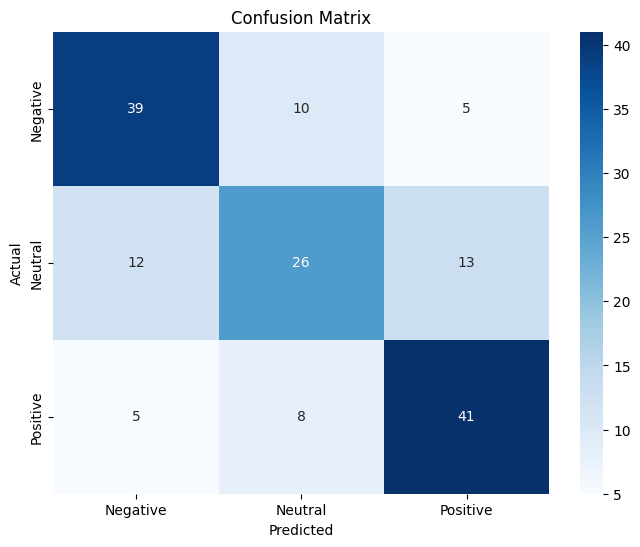

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import random

# 1. Download stopwords and preprocess data
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# 2. Data augmentation (placeholder function for synonyms)
def augment_text(text):
    words = text.split()
    augmented = words.copy()
    if len(words) > 1:
        num_words_to_replace = random.randint(1, 2)  # Randomly replace 1 or 2 words
        for _ in range(num_words_to_replace):
            random_index = random.randint(0, len(words) - 1)
            synonyms = get_synonyms(words[random_index])  # Implement your synonym retrieval here
            if synonyms:
                augmented[random_index] = random.choice(synonyms)
    return ' '.join(augmented)

def get_synonyms(word):
    # Return a list of synonyms; placeholder function
    return [word]  # You can implement an actual synonym retrieval method here

# 3. Load dataset and preprocess
df = pd.read_csv('newone.csv', encoding='Windows-1252')
df.dropna(subset=['text', 'labels'], inplace=True)  # Drop rows with missing text or labels
df['text'] = df['text'].apply(preprocess_text).apply(augment_text)  # Preprocess and augment text

X = df['text'].values
y = df['labels'].values

# 4. Load GloVe embeddings
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# 5. Create embedding matrix using GloVe embeddings
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 6. Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(X)
max_length = 100
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# 7. Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 8. K-Fold Cross-Validation and model building
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []
accuracies = []  # List to store accuracies for each fold

for train_index, test_index in kf.split(X_padded):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_train_cat = tf.keras.utils.to_categorical(y_train)  # Convert to one-hot encoding
    y_test_cat = tf.keras.utils.to_categorical(y_test)
    
    # Define and compile the model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')  # Dynamic output layer based on unique labels
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

    # Predict on test set once after training the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy for the current fold and add to the list
    fold_accuracy = accuracy_score(y_test, y_pred_classes)
    accuracies.append(fold_accuracy)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_classes)

# Calculate and print average accuracy
average_accuracy = np.mean(accuracies)
print(f'Average Test Accuracy across all folds: {average_accuracy * 100:.2f}%')

# Generate confusion matrix after all folds
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13. Save model
model.save('sentiment_lstm_model.h5')
